# Interpretabilidade de Machine Learning
Por diante serão retiradas interpretações e insights da aplicação de Machine Learning efetuada neste projeto - uma avaliação das features mais importantes, motivações por trás das mesmas, e leitura do significado deste cenário quanto a nossos objetivos globais.

## Carregamento do Modelo

In [1]:
import pandas as pd
import pickle

rst = 42 # Random state

In [2]:
with open('../models/model.pkl', 'rb') as fpkl:
    model = pickle.load(fpkl)

In [3]:
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Conjunto de dados

In [13]:
dataset = pd.read_csv('../data/raw/preprocessed/dataset.csv')
dataset.head(5)

,uf_res_dif_paciente,mun_res_dif_paciente,cod_idade,num_idade,sexo,trat_anter,car_atend,rf_tomografos_computadorizados,rf_mamografos,rfressonancia_magnetica,...,Rural Adjacente,Rural Remoto,Sem classificação,Urbano,raca_cor_1,raca_cor_2,raca_cor_3,raca_cor_4,raca_cor_5,raca_cor_99
0,0.0,1.0,4.0,71.0,0,1,1.0,4.0,4.0,2.0,...,0,0,0,1,0,0,1,0,0,0
1,0.0,1.0,4.0,70.0,1,0,1.0,1.0,3.0,1.0,...,0,0,0,1,0,0,1,0,0,0
2,0.0,1.0,4.0,81.0,0,0,1.0,2.0,3.0,1.0,...,0,0,0,1,1,0,0,0,0,0
3,0.0,1.0,4.0,30.0,0,0,1.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1
4,0.0,1.0,4.0,3.0,1,0,1.0,12.0,11.0,5.0,...,0,0,0,1,0,0,0,0,0,1


In [15]:
from sklearn.model_selection import train_test_split

X = dataset.drop('tardio', axis=1)
y = dataset['tardio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Permutation Importance

Ao analisar as predições do modelo criado, podemos inferir a fração mais importante do feature space - assim mensurando o impacto de cada uma delas, em cruzamento com a influência esperada dados os conhecimentos de negócio.

In [16]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=rst).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0281 ± 0.0038,tempo_autorizar
0.0110 ± 0.0037,raca_cor_99
0.0105 ± 0.0037,num_idade
0.0073 ± 0.0032,qtd_estab_uf
0.0057 ± 0.0024,distancia_paciente_estab
0.0032 ± 0.0027,rh_enfermeiros
0.0029 ± 0.0025,rf_leitos_de_internacao
0.0024 ± 0.0005,trat_anter
0.0019 ± 0.0032,GVA_SERVICES
0.0018 ± 0.0024,tempo_atend_identificacao


A escala das 5 principais features, neste caso, permanecem em suas respectivas posições mesmo considerando os extremos dos 'desvios-padrão' dos pesos individuais. Portanto, dentro da permutation importance, essas são - dentro da perspectiva do modelo - as features mais impactantes assim que permutadas. Por extenso:

1. O tempo entre solicitação e autorização de atendimento, `tempo_autorizar`
2. Idade, `num_idade`
3. Etnia, `raca_cor`
4. Distância entre a residência do paciente e o estabelecimento de atendimento, `distancia_paciente_estab`
5. Tempo entre o atendimento e a primeira identificação de patologia no paciente, `tempo_atend_identificacao`

## Partial Plots

Visualizações em plots parciais ajudam a revelar como features específicas de uma mesma árvore influenciam no target, quando variadas de maneira isolada. Iremos utilizar esta técnica para traçar conexões entre features nas árvores de decisões que definem o modelo treinado.

In [59]:
import csv

with open('../data/raw/features.csv', encoding='utf-8') as feats:
    feature_names = [name for idx, name in list(csv.reader(feats))]

In [111]:
from sklearn.tree import DecisionTreeClassifier
from math import sqrt

tree = DecisionTreeClassifier(criterion='entropy', max_features=int(sqrt(len(X_train.columns))), max_depth=8)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
            max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [21]:
from sklearn.tree import export_graphviz
import graphviz

export_graphviz(tree, out_file='tree.dot', feature_names=X_train.columns, max_depth=3)

# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [34]:
## Outra forma de visualizar 

In [112]:
from sklearn.externals.six import StringIO
import pydotplus
from IPython.display import Image

dot_data = StringIO()
export_graphviz(tree, out_file=dot_data, feature_names=X_train.columns.to_list(), class_names=['Precoce', 'Tardio'],
                filled=True, rounded=True, proportion=True, max_depth=3)

In [113]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

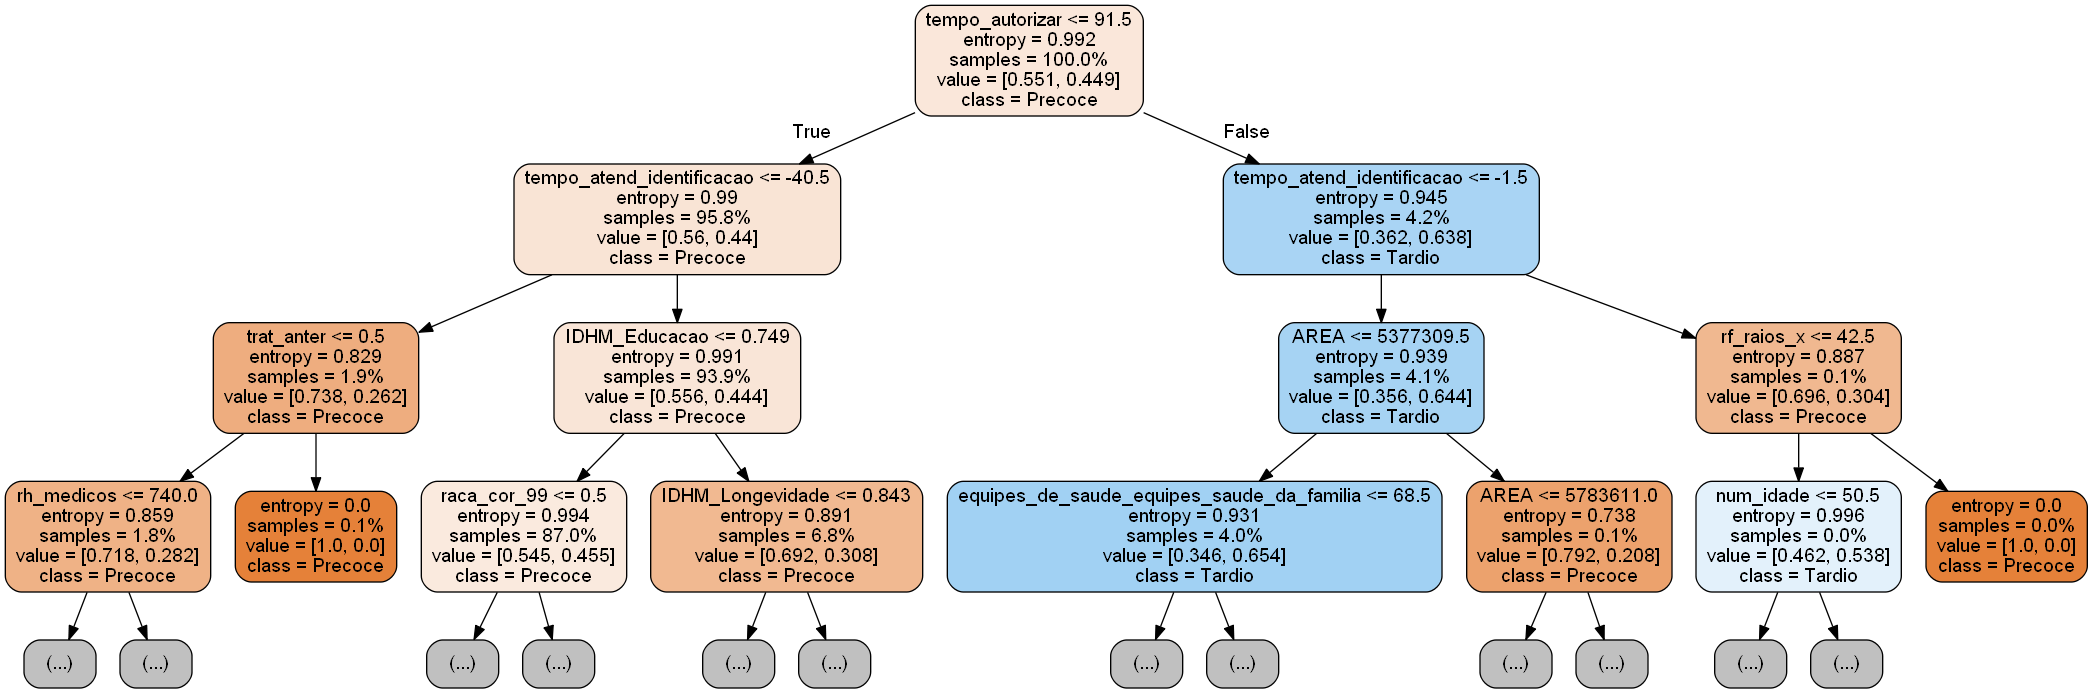

In [114]:
Image(graph.create_png())

In [ ]:
# graph.write_png('tree.png')

### Partial Dependence Plot

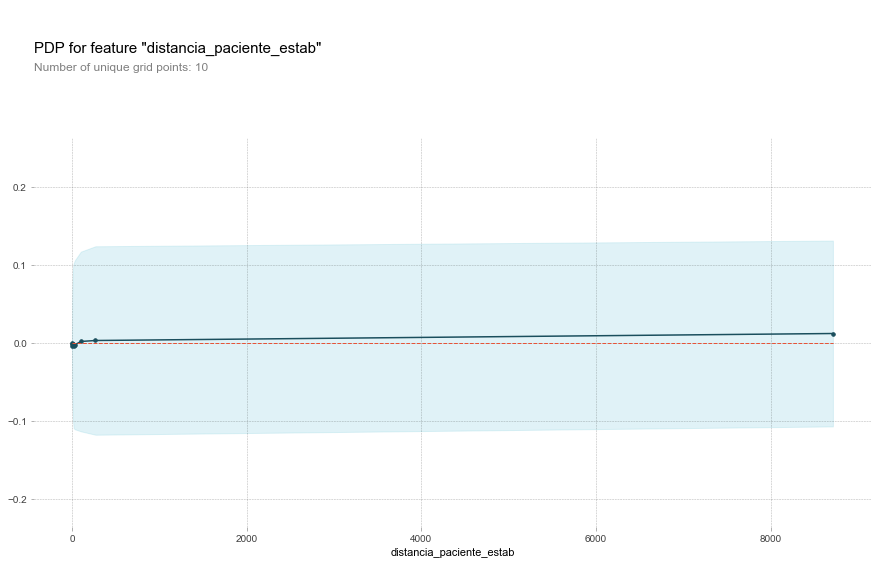

In [66]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=model, dataset=X_test, model_features=feature_names, feature='distancia_paciente_estab')

# plot it
pdp.pdp_plot(pdp_goals, 'distancia_paciente_estab')
plt.show()

### SHAP

In [ ]:
import shap 

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test)